## Titanic Survivor Prediction
- Pre-processing the data
    - Drop out features which are not useful
    - Data Imputation (Fill the missing values)
- Create a decision tree

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [65]:
data = pd.read_csv('titanic.csv')

In [66]:
data.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Pre-processing

In [68]:
columns_to_drop = ['PassengerId','Name','Ticket','Cabin','Embarked']

In [69]:
clean_data = data.drop(columns_to_drop,axis=1)

In [70]:
clean_data.head(n=10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
5,0,3,male,NaN,0,0,8.4583
6,0,1,male,54.0,0,0,51.8625
7,0,3,male,2.0,3,1,21.0750
8,1,3,female,27.0,0,2,11.1333
9,1,2,female,14.0,1,0,30.0708


In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clean_data['Sex'] = le.fit_transform(clean_data['Sex'])

In [72]:
clean_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [73]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [74]:
clean_data = clean_data.fillna(clean_data['Age'].mean())

In [75]:
clean_data.loc[2]

Survived     1.000
Pclass       3.000
Sex          0.000
Age         26.000
SibSp        0.000
Parch        0.000
Fare         7.925
Name: 2, dtype: float64

In [76]:
input_cols = ['Pclass','Sex','Age','SibSp','Parch','Fare']
output_cols = ['Survived']
X = clean_data[input_cols]
Y = clean_data[output_cols]
print(X.shape,Y.shape)

(891, 6) (891, 1)


### Entropy & Information Gain

In [77]:
def entropy(col):
    counts = np.unique(col,return_counts=True)
    N = col.shape[0]
    ent = 0.0
    for i in counts[1]:
        p = i/N
        ent += -1.0*p*np.log2(p)
    return ent

In [78]:
def divide_data(x_data,fkey,fval):
    x_right = pd.DataFrame([],columns=x_data.columns)
    x_left = pd.DataFrame([],columns=x_data.columns)
    for ix in range(x_data.shape[0]):
        val = x_data[fkey].loc[ix]
        if val>fval:
            x_right = x_right.append(x_data.loc[ix])
        else:
            x_left = x_left.append(x_data.loc[ix])
    return x_left,x_right

In [79]:
def information_gain(x_data,fkey,fval):
    left,right = divide_data(x_data,fkey,fval)
    # if all samples are of one type only
    if left.shape[0]==0 or right.shape[0]==0:
        return -1000000 # Min Information gain
    l = left.shape[0]/x_data.shape[0]
    r = right.shape[0]/x_data.shape[0]
    i_gain = entropy(x_data.Survived) - (l*entropy(left.Survived)+r*entropy(right.Survived))
    return i_gain

In [80]:
# Testing the functions
for fx in X.columns:
    print(fx)
    print(information_gain(clean_data,fx,clean_data[fx].mean()))

Pclass
0.07579362743608165
Sex
0.2176601066606142
Age
0.0008836151229467681
SibSp
0.009584541813400071
Parch
0.015380754493137916
Fare
0.042140692838995464


### Decision Tree Implementation

To prevent overfitting 2 methods are used :
- Post Pruning
- Early stopping

In [81]:
class DecisionTree:
    def __init__(self,depth=0,max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
    
    def train(self,X_train):
        features = ['Pclass','Sex','Age','SibSp','Parch','Fare']
        info_gains = []
        for ix in features:
            i_gain = information_gain(X_train,ix,X_train[ix].mean())
            info_gains.append(i_gain)
        self.fkey = features[np.argmax(info_gains)]
        self.fval = X_train[self.fkey].mean()
        print('Making tree with Feature',self.fkey)
        # Split data
        data_left,data_right = divide_data(X_train,self.fkey,self.fval)
        data_left = data_left.reset_index(drop=True)
        data_right = data_right.reset_index(drop=True)
        # Leaf Node occurs
        if data_left.shape[0]==0 or data_right.shape[0]==0:
            if X_train.Survived.mean()>=0.5:
                self.target = 'Survive'
            else:
                self.target = 'Dead'
            return
        # Max depth is reached
        if self.depth>=self.max_depth:
            if X_train.Survived.mean()>=0.5:
                self.target = 'Survive'
            else:
                self.target = 'Dead'
            return
        # Recursive case
        self.left = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.left.train(data_left)
        self.right = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.right.train(data_right)
        # Set target at every node
        if X_train.Survived.mean()>=0.5:
            self.target = 'Survive'
        else:
            self.target = 'Dead'
        return
    
    def predict(self,test):
        if test[self.fkey]>self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(test)

### Train-Test Split

In [82]:
split = int(0.7*clean_data.shape[0])
train_data = clean_data[:split]
test_data = clean_data[split:]
test_data = test_data.reset_index(drop=True)

In [83]:
print(train_data.shape,test_data.shape)

(623, 7) (268, 7)


In [84]:
dt = DecisionTree()
dt.train(train_data)

Making tree with Feature Sex
Making tree with Feature Pclass
Making tree with Feature Age
Making tree with Feature SibSp
Making tree with Feature Pclass
Making tree with Feature Age
Making tree with Feature Age
Making tree with Feature SibSp
Making tree with Feature Parch
Making tree with Feature Pclass
Making tree with Feature SibSp
Making tree with Feature Fare
Making tree with Feature Parch
Making tree with Feature Age
Making tree with Feature Pclass
Making tree with Feature Age
Making tree with Feature Age
Making tree with Feature Parch
Making tree with Feature SibSp
Making tree with Feature Fare
Making tree with Feature Age
Making tree with Feature Age
Making tree with Feature Fare
Making tree with Feature Age
Making tree with Feature Age
Making tree with Feature Fare
Making tree with Feature Age
Making tree with Feature Parch
Making tree with Feature Fare
Making tree with Feature Fare
Making tree with Feature Fare
Making tree with Feature Age
Making tree with Feature Fare
Making 

In [85]:
print(dt.fkey)
print(dt.fval)
print(dt.left.fkey,dt.right.fkey)

Sex
0.6292134831460674
Pclass Fare


In [86]:
y_pred = []
for ix in range(test_data.shape[0]):
    y_pred.append(dt.predict(test_data.loc[ix]))
print(y_pred)

['Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Survive', 'Dead', 'Survive', 'Survive', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Survive', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Survive', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Survive', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Survive', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survive', 'Survive', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Survive', 'Dead', 'Survive', 'Survive', 'Dead', 'Dead', 'Survive', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 

In [87]:
y_actual = test_data[output_cols]
le = LabelEncoder()
y_pred = le.fit_transform(y_pred)
print(y_pred)
print(y_pred.shape)
print(y_actual.shape)
y_pred = y_pred.reshape((-1,1))

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 0]
(268,)
(268, 1)


In [108]:
acc = np.sum(np.array(y_pred)==np.array(y_actual))/y_pred.shape[0]
print(acc)

0.8171641791044776


### Decision Tree using SKlearn

In [109]:
from sklearn.tree import DecisionTreeClassifier

In [110]:
sk_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
sk_tree.fit(train_data[input_cols],train_data[output_cols])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [111]:
sk_tree.predict(test_data[input_cols])

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0])

In [112]:
sk_tree.score(test_data[input_cols],test_data[output_cols])

0.8283582089552238

### Visualize the Decision Tree

In [113]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

In [114]:
dot_data = StringIO()
export_graphviz(sk_tree,out_file=dot_data,filled=True,rounded=True)

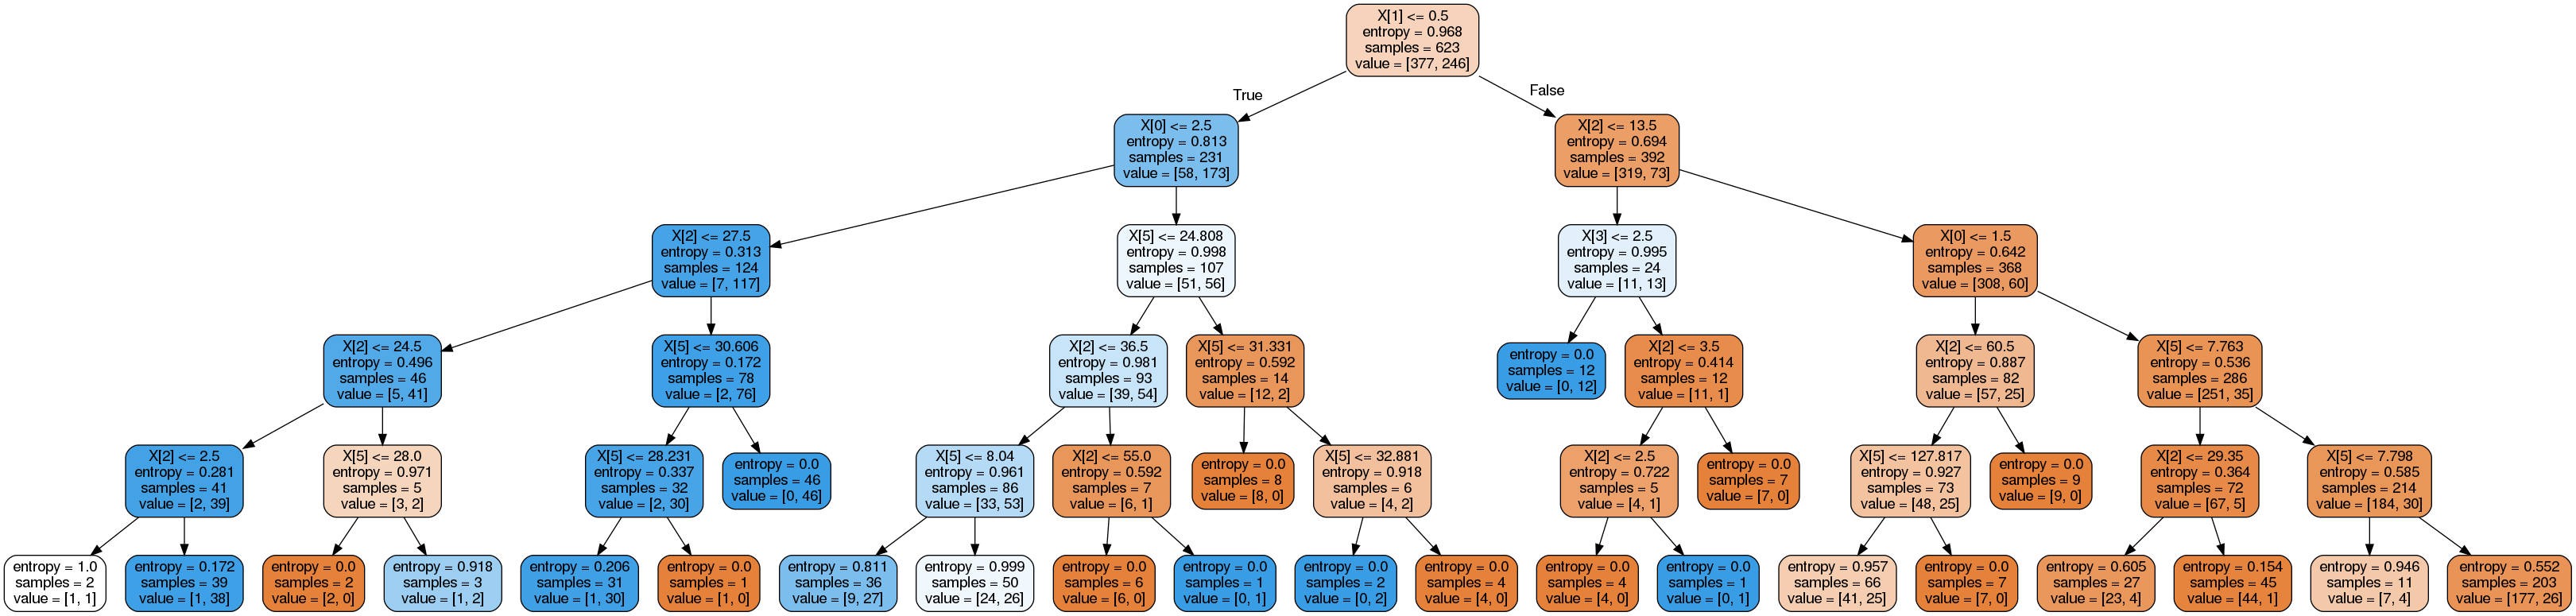

In [115]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [116]:
# Finding Accuracy
X_train = train_data[input_cols]
Y_train = np.array(train_data[output_cols]).reshape((-1,))
X_test = test_data[input_cols]
Y_test = np.array(test_data[output_cols]).reshape((-1,))

In [117]:
sk_tree = DecisionTreeClassifier(criterion='entropy')
sk_tree.fit(X_train,Y_train)
sk_tree.score(X_train,Y_train)

0.9823434991974318

In [118]:
sk_tree.score(X_test,Y_test) # Overfitted, therefore use maxDepth

0.7723880597014925

### Random Forests

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
rf = RandomForestClassifier(n_estimators=10,criterion="entropy",max_depth=5)

In [121]:
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [122]:
rf.score(X_train,Y_train)

0.8603531300160514

In [123]:
rf.score(X_test,Y_test)

0.8283582089552238

In [124]:
from sklearn.model_selection import cross_val_score

In [125]:
acc = cross_val_score(RandomForestClassifier(n_estimators=10,max_depth=5,criterion='entropy'),X_train,Y_train,cv=5).mean()

In [126]:
print(acc)

0.8186580645161291


In [132]:
acc_list = []
for i in range(1,50):
    acc = cross_val_score(RandomForestClassifier(n_estimators=i,max_depth=5,criterion='entropy'),X_train,Y_train,cv=5).mean()
    acc_list.append(acc)
print(acc_list)

[0.7817161290322582, 0.7720774193548388, 0.770541935483871, 0.8041419354838709, 0.7992774193548386, 0.7945806451612902, 0.8137935483870968, 0.8025032258064517, 0.8121290322580645, 0.820232258064516, 0.8057548387096773, 0.8074064516129031, 0.8137935483870967, 0.8041806451612903, 0.8089419354838709, 0.8202193548387097, 0.8314967741935485, 0.8201935483870969, 0.8217935483870967, 0.8025290322580645, 0.8105419354838709, 0.8298193548387097, 0.8122064516129033, 0.8057548387096773, 0.8073161290322581, 0.8089161290322581, 0.8073161290322581, 0.8153290322580645, 0.8186064516129032, 0.8250322580645161, 0.8121677419354839, 0.8233677419354839, 0.8201290322580645, 0.8137419354838709, 0.8297677419354839, 0.8185677419354839, 0.8121290322580645, 0.8233935483870967, 0.8153419354838709, 0.8201548387096775, 0.8217935483870967, 0.8233290322580645, 0.8089419354838709, 0.8121290322580645, 0.8201677419354837, 0.8233935483870967, 0.8105161290322581, 0.8169290322580645, 0.8249935483870967]


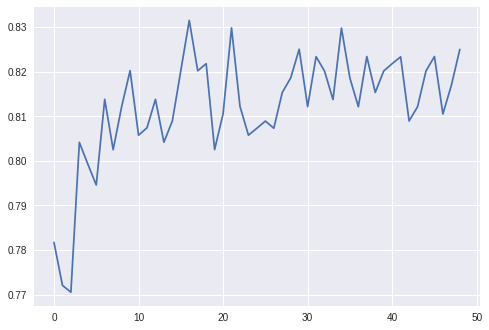

In [134]:
plt.plot(acc_list)
plt.show()

In [138]:
max_est = np.argmax(acc_list)
print(max_est)

16


In [154]:
rf = RandomForestClassifier(n_estimators=max_est+1,criterion="entropy",max_depth=5)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [152]:
rf.score(X_train,Y_train)

0.8571428571428571

In [153]:
rf.score(X_test,Y_test)

0.832089552238806